In [1]:
import pandas as pd
import numpy as np
import scipy.integrate as integrate
import scipy.stats as ss
from statsmodels.distributions.empirical_distribution import ECDF

import geopandas as gp
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [17]:
# Import plotting shapefiles
county_shp = gp.read_file('../../data/conus_shp/conus_plot/final/counties_contig_plot.shp')
county_shp["GEOID"] = county_shp["GEOID"].astype(str).str.zfill(5)

states = gp.read_file('../../data/conus_shp/conus_plot/final/states_contig_plot.shp')
coast = gp.read_file('../../data/conus_shp/conus_plot/final/coast_contig_plot.shp')

In [19]:
cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/cork/cork.txt")[::-1]
cork_map = LinearSegmentedColormap.from_list("Cork", cm_data)

# Yield Ratios

## USDA and GMFD data

In [2]:
nex = pd.read_csv('./data/nex_yr_hist.csv')
nex['GEOID'] = nex["GEOID"].astype(str).str.zfill(5)
nex['state'] = nex['state'].astype(str).str.zfill(2)
cmip = pd.read_csv('./data/cmip_yr_hist.csv')
cmip['GEOID'] = cmip["GEOID"].astype(str).str.zfill(5)
cmip['state'] = cmip['state'].astype(str).str.zfill(2)

In [8]:
nex.head()

,state,GEOID,Year,ACCESS1-0,BNU-ESM,CCSM4,CESM1-BGC,CNRM-CM5,CSIRO-Mk3-6-0,CanESM2,...,MIROC5,MPI-ESM-LR,MPI-ESM-MR,MRI-CGCM3,NorESM1-M,bcc-csm1-1,inmcm4,ensemble_mean,GMFD,USDA
0,01,01001,1957,0.828573,1.272913,1.040988,1.439364,0.331421,0.904028,0.936979,...,1.069306,0.395659,0.869864,1.168197,1.065786,1.048710,0.495656,0.905856,1.151336,0.883780
1,01,01001,1958,1.517625,1.065373,0.803372,1.034587,1.390957,1.184180,1.053928,...,1.084054,2.310058,0.714898,0.812949,1.088321,0.958057,1.907339,1.032762,1.061482,1.402721
2,01,01001,1959,0.916051,1.040767,1.513098,0.791448,1.642304,1.039048,0.955314,...,0.990682,0.889763,1.144682,1.364829,0.999322,0.896425,0.994655,1.065922,0.828322,0.753608
3,01,01001,1960,0.994391,0.820783,1.025949,1.122950,1.290372,0.931569,1.332422,...,0.724807,1.041737,1.229659,0.932624,1.093996,0.747698,0.945533,1.030034,1.048721,1.080650
4,01,01001,1961,1.120659,0.994490,0.787367,1.133441,0.856447,0.976951,0.928305,...,1.198338,0.690834,0.665702,1.008902,0.971864,1.028988,0.489931,0.897143,1.286738,1.102987


In [22]:
%%time
# NEX Yield
res = []
nnex = nex.query('Year >= 1980 and Year <= 2005')
for geoid in nnex['GEOID'].unique():
    ens = nnex.query('GEOID == "' + geoid + '"').drop(columns = ['USDA', 'GMFD', 'GEOID', 'ensemble_mean', 'Year', 'state']).values.flatten()
    obs = nnex.query('GEOID == "' + geoid + '"')['GMFD'].values.flatten()

    ens_pdf = ss.gaussian_kde(ens)
        
    likes = ens_pdf.evaluate(obs)
        
    res.append({'GEOID' : geoid, 'likelihood' : np.prod(likes)})

CPU times: user 33.9 s, sys: 312 ms, total: 34.2 s
Wall time: 37.6 s


In [23]:
NexRes = pd.DataFrame(res)
NexRes.set_index(['GEOID'], inplace = True)

In [24]:
NexRes.head()

,likelihood
GEOID,
01001,0.021934
01003,0.487262
01005,0.000866
01007,0.041834
01009,1.152620


In [25]:
%%time
# CMIP Yield
res = []
ccmip = cmip.query('Year >= 1980 and Year <= 2005')
for geoid in ccmip['GEOID'].unique():
    ens = ccmip.query('GEOID == "' + geoid + '"').drop(columns = ['GEOID', 'USDA', 'GMFD', 'ensemble_mean', 'Year', 'state']).values.flatten()
    obs = ccmip.query('GEOID == "' + geoid + '"')['GMFD'].values.flatten()

    ens_pdf = ss.gaussian_kde(ens)
        
    likes = ens_pdf.evaluate(obs)
        
    res.append({'GEOID' : geoid, 'likelihood' : np.prod(likes)})

CPU times: user 33.6 s, sys: 277 ms, total: 33.8 s
Wall time: 34.2 s


In [26]:
cmipRes = pd.DataFrame(res)
cmipRes.set_index(['GEOID'], inplace = True)

In [27]:
cmipRes.head()

,likelihood
GEOID,
01001,0.007224
01003,0.061554
01005,0.000255
01007,0.016167
01009,0.126820


In [28]:
res = pd.merge(NexRes, cmipRes, on = ['GEOID'])
res['ratio'] = res['likelihood_x'] / res['likelihood_y']
res.drop(columns = ['likelihood_x', 'likelihood_y'], inplace = True)
res['logratio'] = np.log10(res['ratio'])

In [29]:
res.head()

,ratio,logratio
GEOID,,
01001,3.036321,0.482348
01003,7.915998,0.898506
01005,3.394136,0.530729
01007,2.587664,0.412908
01009,9.088605,0.958497


In [30]:
res.to_csv('./data/YR_likelihood_ratio_gmfd_80-05.csv')

In [14]:
def PlotYield(data, model, title, vmin, vmax, cmap, save=False):
    """
    Plots the county-level map of a pre-calculated verification metric for one model

    Inputs:
        - data: Pandas DataFrame of pre-calculated verification metric for all models
        - model: String of model name to be plotted
        - metric: String of metric (to be used in plot asthetics)
        - vmin/vmax : Min/Max values to be plotted
        - cmap: Colormap to use in plot ('batlow' or 'broc')
        - save: Boolean, savefig or not
    """
    # Merge county-level shapefile with data
    data = data.reset_index()
    data['GEOID'] = data["GEOID"].astype(str).str.zfill(5)
    data.set_index(['GEOID'], inplace=True)
    data_shp = pd.merge(county_shp, data.filter([model]), on="GEOID", how="outer", copy=False)
    # Do the plot!
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cax.tick_params(labelsize=20)
    data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=globals()[cmap + '_map'], vmin=vmin, vmax=vmax)
    data_shp[data_shp[model].isna()].plot(ax=ax, color="lightgray")
    states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
    coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

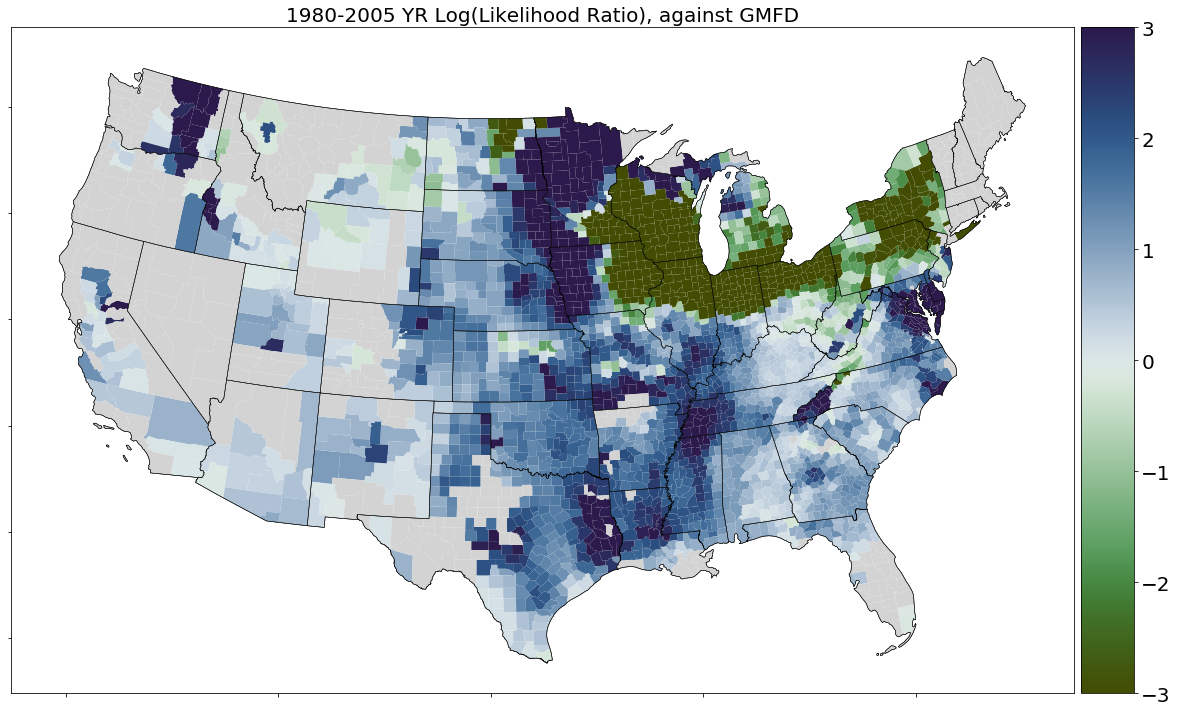

In [31]:
PlotYield(res, 'logratio', '1980-2005 YR Log(Likelihood Ratio), against GMFD', -3., 3., 'cork')

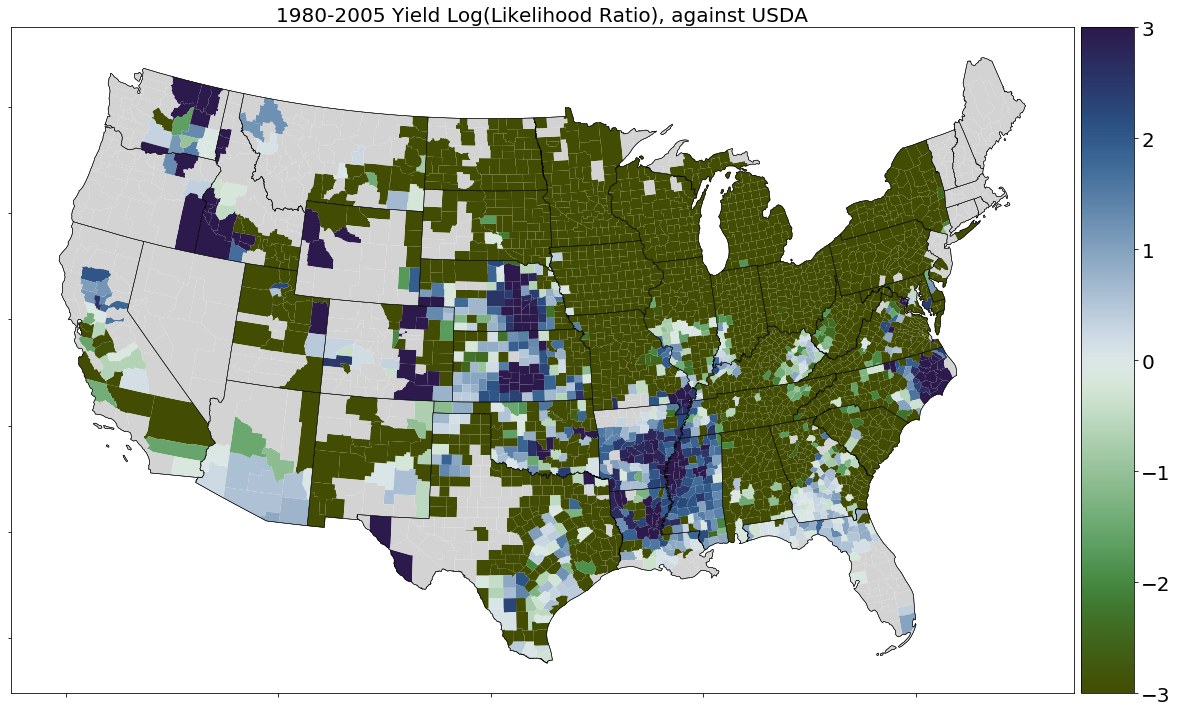

In [20]:
PlotYield(res, 'logratio', '1980-2005 YR Log(Likelihood Ratio), against USDA', -3., 3., 'cork')